# Проект: бинарная классификация

In [192]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from  sklearn.ensemble import IsolationForest
from sklearn.preprocessing  import LabelEncoder, LabelBinarizer
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

# делаем визуальную настройку графиков
sns.set_palette("Set2") 
sns.set_theme(style="dark")

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [193]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [194]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

*Пропуски есть только в признаке balance*

### Задание 2

In [195]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

df.job.value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

*В признаке job пропущенные значения заменены словом unknown*

### Задание 3

In [196]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

def balance_convert(balance):
    '''
    Функия balance_convert принимает строковое значение,
    а возвращает обработанное значение в формате float.
    Если поданное в функию значени уже является вещественным,
    то она просто возвращает это значение без изменений
    '''
    # Проверяем, является ли значение типа float
    if type(balance) is float:
        return balance
    else:
        # Удаляем все пробелы из строки
        balance = balance.replace(' ', '')
        # Удаляем знак доллара '$', если он есть
        balance = balance.replace('$', '')
        # Заменяем запятую на точку, чтобы корректно преобразовать в float
        balance = balance.replace(',', '.')
        # Преобразуем очищенную строку в число с плавающей точкой и возвращаем
        return float(balance)

# Применяем функцию balance_convert ко всем элементам столбца 'balance' в датафрейме df
df.balance = df.balance.map(balance_convert)

print(f'Среднее значение по преобразованному в корректный вид признаку balance равно {df.balance.mean():.3f}')

Среднее значение по преобразованному в корректный вид признаку balance равно 1529.129


### Задание 4

In [197]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df.balance = df.balance.fillna(value=df.balance.median())
print(f'Среднее значение после заполнения пропусков признака balance равно {df.balance.mean():.3f}')

Среднее значение после заполнения пропусков признака balance равно 1526.936


### Задание 5

In [198]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

# Найдем модальное значение для job и education
job_mode = df.job.mode().iloc[0]
educ_mode = df.education.mode().iloc[0]

# Заменяем все значения 'unknown' в столбце job и education на найденную моду
df.job = df.job.map(lambda x: job_mode if x == 'unknown' else x)
df.education = df.education.map(lambda x: educ_mode if x == 'unknown' else x)

# Рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
query_balance =  df.query('(job == @job_mode) & (education == @educ_mode)').balance.mean()
print(f'Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования равен {query_balance:.3f}')

Средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования равен 1598.883


### Задание 6

In [199]:
# удалите все выбросы для признака balance

# Напишем функицию для определения границ очистки данных методом Тьюкки:
def tukey_borders(data, feature):
    '''
    Функция tukey_borders принимает датафрейм для обработки,
    а также признак, для которого нужно удалить выбросы.
    Функция возвращает кортеж из 2х значений:
    верхнюю и нижнюю границы для выбросов, посчитанные
    с помошью метода Тьюкки
    '''
    x = data[feature]
    
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    
    return lower_bound, upper_bound

lower_bound, upper_bound = tukey_borders(df, 'balance')
df_cleaned = df.query('(balance >= @lower_bound) & (balance <= @upper_bound)')

print(f'Нижняя граница равна {lower_bound}, верхняя {upper_bound}')
print(f'Количество объектов после удаления всех выбросов равно {df_cleaned.shape[0]}')

Нижняя граница равна -2241.0, верхняя 4063.0
Количество объектов после удаления всех выбросов равно 10105


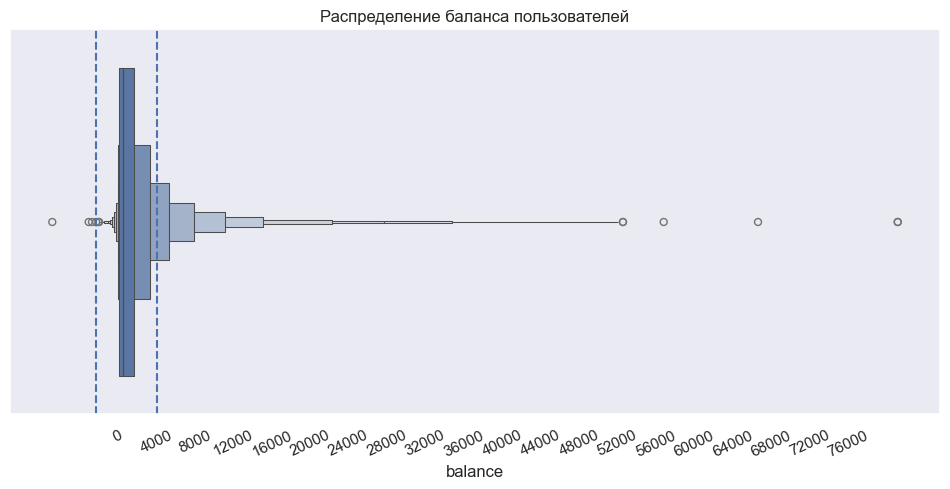

In [200]:
# Посмотрим на распределение призанака balance
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

sns.boxenplot(df.balance,
              orient='h',
              ax=ax);

ax.set_title('Распределение баланса пользователей')

# Отметим значения, которые мы считаем границей выбросов
ax.axvline(x=lower_bound, linestyle='--')
ax.axvline(x=upper_bound, linestyle='--')

ax.xaxis.set_tick_params(rotation = 25)
ax.set_xticks(np.arange(0, 80000, 4000));


*Из графика видно насколько сильно растянуты наши данные. Пунктирные линии показывают, какие данные мы оставляем, а какие считаем выбросами и удаляем из датасета (оставляем только те значения, которые находятся между этих двух линий). По итогу мы достаточно сильно ограничили наш датасет*

## Часть 2:  Разведывательный анализ

### Задание 1

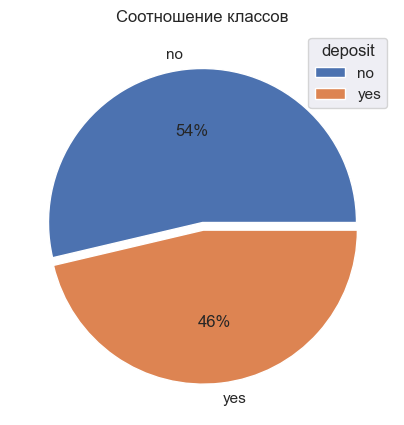

In [201]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.pie(df_cleaned.deposit.value_counts(),
            labels = df_cleaned.deposit.value_counts().index,
            explode = [0, 0.05],
            autopct='%.0f%%')

ax.set_title('Соотношение классов')
ax.legend(title='deposit');

*Как мы видим соотношение классов по признаку deposit достаточно сбалансировано*

In [202]:
print(f'Количество клиентов, открывших депозит равно {df_cleaned.deposit.value_counts()[1]}')

Количество клиентов, открывших депозит равно 4681


### Задания 2 и 3

In [203]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

df_cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


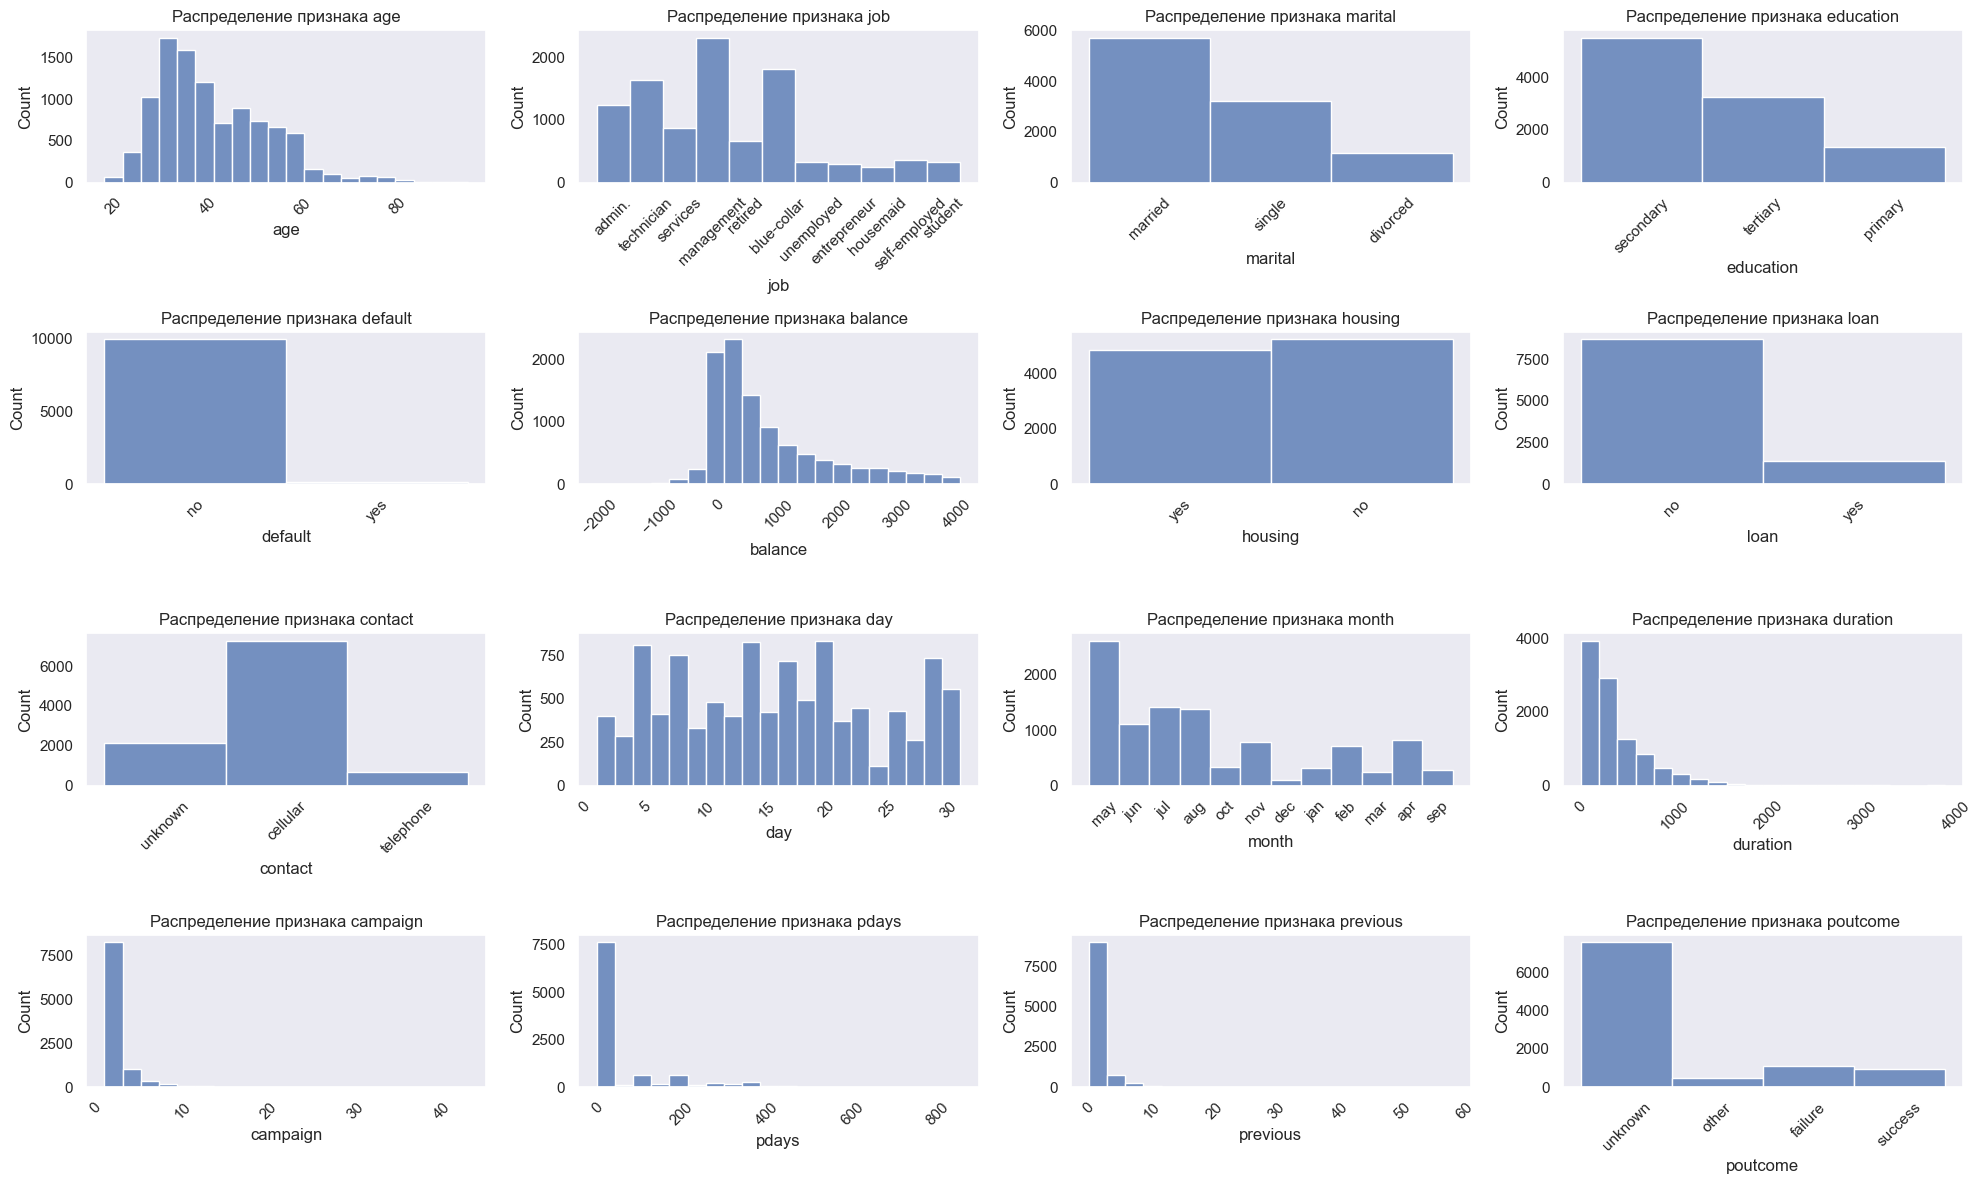

In [204]:
# Построим гистограммы распределения для признаков датасета
fig, ax = plt.subplots(4, 4, figsize=(20,12)) 
for i, column in enumerate(df.columns):
    if column != 'deposit':  # Пропускаем столбец 'deposit', так как он является таргетом
        sns.histplot(df_cleaned, x=column, ax=ax[i//4, i%4], bins=20)
        ax[i//4, i%4].set_title(f'Распределение признака {column}')
        ax[i//4, i%4].xaxis.set_tick_params(rotation=45)
    else:
        break  # Прерываем цикл, если достигнут столбец 'deposit'
fig.tight_layout()  


*В большинстве своем признаки распределены несбалансированно, нормального распредения данных не наблюдается. Можно однозначно сказать, перед тем, как передавать данные в модели для предсказания, их нужно будет преобразовать*

### Задания 4 и 5

In [205]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

df_cleaned.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


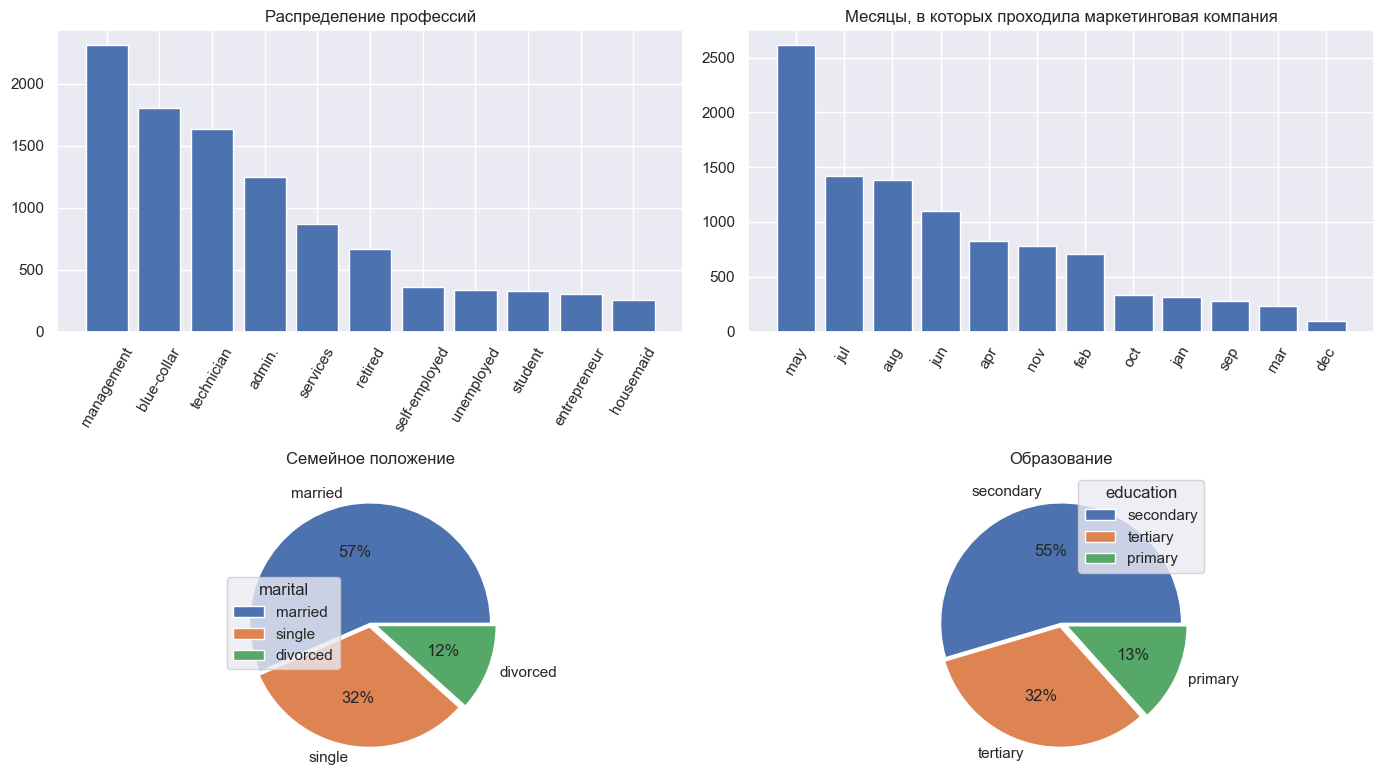

In [206]:
# Посмотрим на распределение некоторых признаков детальнее
fig, ax = plt.subplots(2, 2, figsize=(14,8)) 

ax[0, 0].bar(df_cleaned.job.value_counts(ascending=False).index,
              df_cleaned.job.value_counts(ascending=False))
ax[0, 0].xaxis.set_tick_params(rotation=60)
ax[0, 0].set_title('Распределение профессий') 
ax[0, 0].grid()

ax[0, 1].bar(df_cleaned.month.value_counts(ascending=False).index,
              df_cleaned.month.value_counts(ascending=False))
ax[0, 1].xaxis.set_tick_params(rotation=60)
ax[0, 1].set_title('Месяцы, в которых проходила маркетинговая компания') 
ax[0, 1].grid()

ax[1, 0].pie(df_cleaned.marital.value_counts(),
            labels = df_cleaned.marital.value_counts().index,
            explode = [0, 0.03, 0.05],
            autopct='%.0f%%')

ax[1, 0].set_title('Семейное положение')
ax[1, 0].legend(title='marital');

ax[1, 1].pie(df_cleaned.education.value_counts(),
            labels = df_cleaned.education.value_counts().index,
            explode = [0, 0.03, 0.05],
            autopct='%.0f%%')

ax[1, 1].set_title('Образование')
ax[1, 1].legend(title='education');

plt.tight_layout();

*Май - с отрывом самый популярный месяц для проведения маркетинговых компаний. Большинство клиентов женаты. Высшее образование имеет лишь треть всех клиентов. Самый популярный вид деятельности - managment.*

### Задание 6

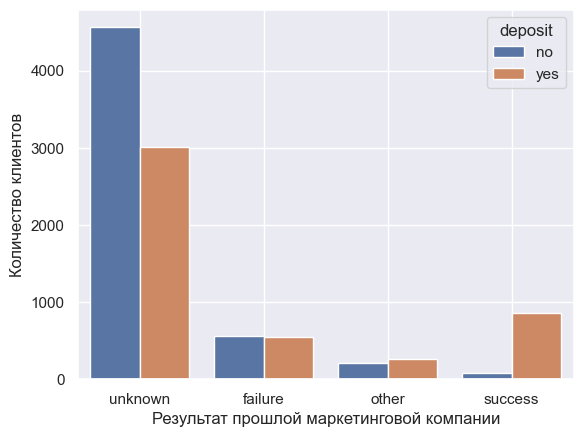

In [207]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

# Сгруппируем данные
groupped = df_cleaned.groupby(by='deposit')['poutcome'].value_counts().reset_index(name='count')

barplot = sns.barplot(groupped, x='poutcome', y='count', hue='deposit',)
barplot.set_xlabel('Результат прошлой маркетинговой компании')
barplot.set_ylabel('Количество клиентов')
barplot.grid();

*Видим, что количество клиентов, которые открыли депозит, превалирует только для успешных маркетинговых компаний. В целом это не удивительно, ведь что нужно считать успехом компании - как раз рост количества депозитов.*

### Задание 7

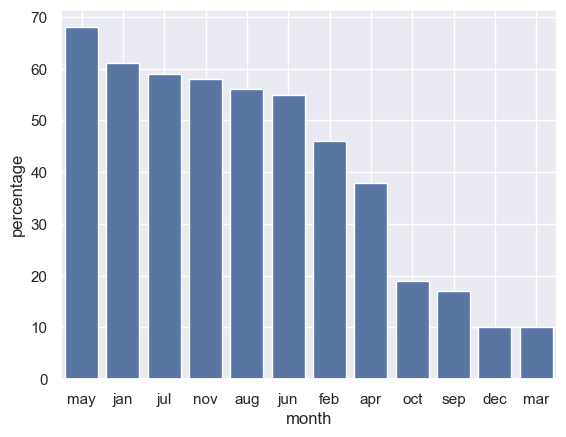

In [208]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

# Сгруппируем данные по интересующих нас значениям
count_total = df_cleaned.groupby(by='month')['deposit'].count()
count_no = df_cleaned.query('deposit=="no"').groupby(by='month')['deposit'].count()

# Соеденим полученные сгруппированные данные в один датафрейм
concat_data = pd.concat([count_total, count_no], axis=1).reset_index()
concat_data.columns = ['month', 'total', 'no']

# Создадам искомый признак процентного соотношения
concat_data['percentage'] = round(concat_data['no']/concat_data['total']*100)
concat_data.sort_values(by='percentage', ascending=False, inplace=True)

sns.barplot(concat_data, x='month', y='percentage')
plt.grid();

*Из графика видим, что май - самый неблагоприятный месяц для проведения маркетинговых компаний - почти 70 % клиентов предпочитают не открывать вклад в этот период. Самыми благоприятными можно назвать декабрь и март - клиент откроет вклад с вероятностью до 90 %*

### Задание 8

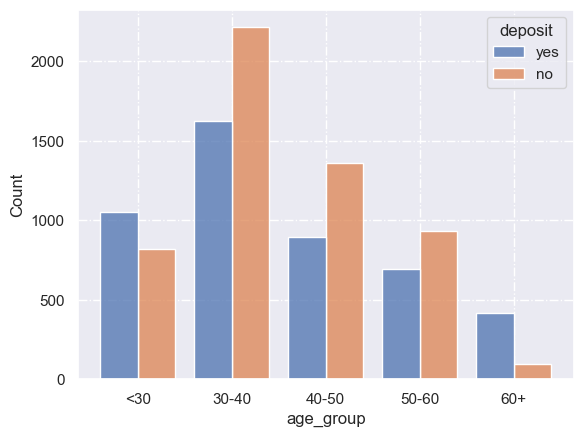

In [209]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# для создания категорий воспользуемся методом cut()

df_cleaned['age_group'] = pd.cut(df.age,
                         [0, 30, 40, 50, 60, 999],
                         labels = ['<30', '30-40', '40-50', '50-60','60+'])

sns.histplot(df_cleaned,
             x='age_group',
             hue='deposit',
             multiple='dodge',
             shrink=0.8)

plt.grid(linestyle='-.')

*Лишь 2 категории клиентов открывают депозит чаще, чем отказываются это сделать - до 30 лет и после 60ти. Причем вторая категория хоть и малочисленна по сравнению с остальными, но имеет куда большую склонность к накоплениям - процент отказа от депозита в данной категории минимален.*

### Задания 9 и 10

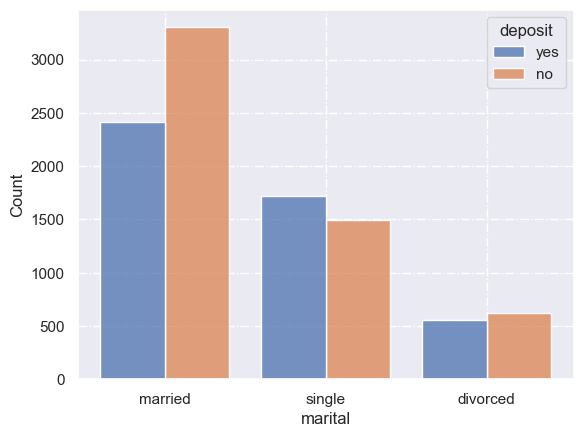

In [210]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

sns.histplot(df_cleaned,
             x='marital',
             hue='deposit',
             multiple='dodge',
             shrink=0.8)

plt.grid(linestyle='-.')

*Женатые клиенты - самая общирная категория, и как следствие в количественном плане открывают депозит чаще остальных. Но вот если смотреть женатых в разрезе процентного соотношения - то они куда более склонны отказаться от открытия депозита, нежели клиенты остальных категорий.*

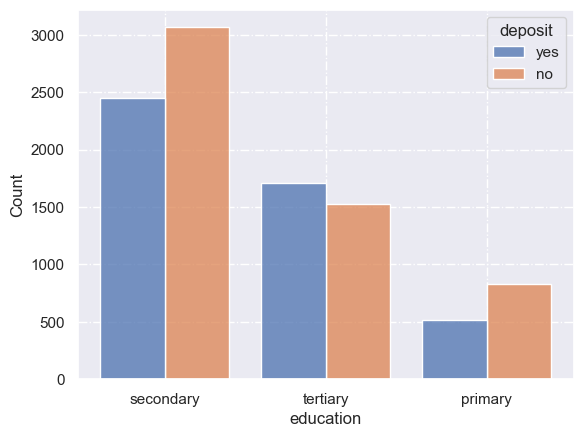

In [211]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

sns.histplot(df_cleaned,
             x='education',
             hue='deposit',
             multiple='dodge',
             shrink=0.8)

plt.grid(linestyle='-.')

*Аналогичная ситуация происходит и с уровнем образования: категория secondary является самой обширной, вследстие чего чаще остальных открывает депозит. Но если смотреть на процентное соотшение, то лидером здесь, безусловно, будет категория tertiary - люди с высшим образованием. В целом это неудивительно, вероятно их уровень дохода выше, чем у остальных, плюс у образованных людей есть понимание финансовой грамотности, что побуждает их думать на перспективу и копить на свое будущее.*

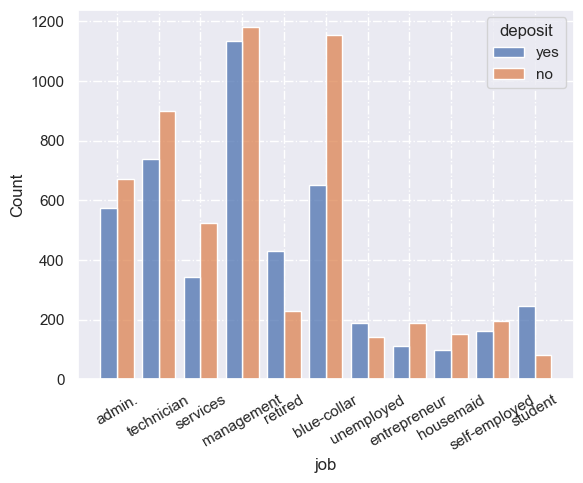

In [212]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

sns.histplot(df_cleaned,
             x='job',
             hue='deposit',
             multiple='dodge',
             shrink=0.8)

plt.xticks(rotation=30)
plt.grid(linestyle='-.')

*Можно заметить, что клиенты самых популярных сфер занятости: management и blue-collar не являтся ярыми любителями открывать депозит. В процентном соотношении любителями накоплений можно назвать клиентов в отставке (retired) и студентов (student). Что кстати, сильно коррелируется с выводом из задания 8: "Лишь 2 категории клиентов открывают депозит чаще, чем отказываются это сделать - до 30 лет и после 60ти"*

### Задание 11

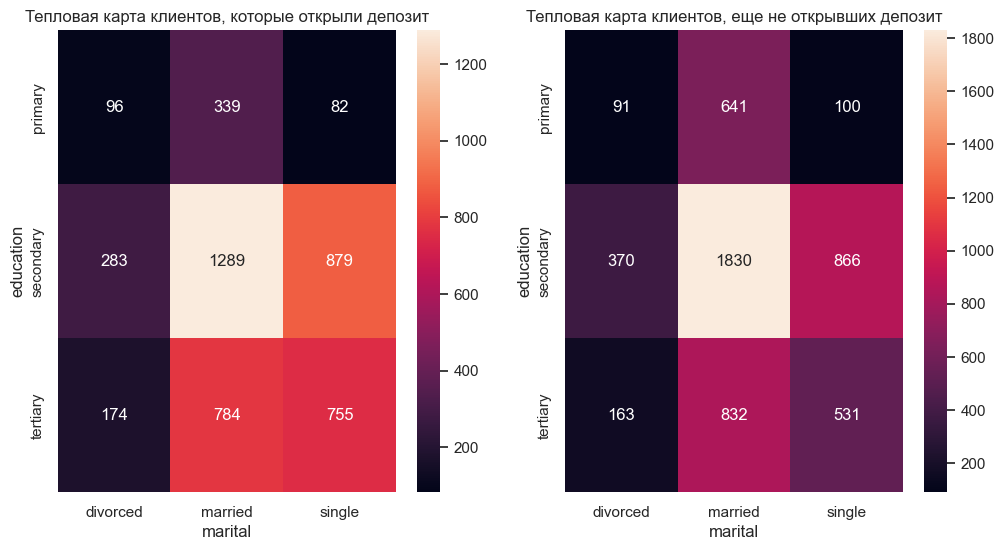

In [213]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# построим сводную таблицу для клиентов, которые открыли депозит
deposit_yes = df_cleaned.query('deposit=="yes"')
pivot_yes = pd.pivot_table(data=deposit_yes, columns='marital', index='education', values='deposit', aggfunc='count')

# построим сводную таблицу для клиентов, которые открыли не стали открывать депозит
deposit_no = df_cleaned.query('deposit=="no"')
pivot_no = pd.pivot_table(data=deposit_no, columns='marital', index='education', aggfunc='count', values='deposit')

# Визуализируем сводыне таблицы в виде тепловых карт
sns.heatmap(pivot_yes, annot=True, ax=ax[0], fmt='.0f')
sns.heatmap(pivot_no, annot=True, ax=ax[1], fmt='.0f')

ax[0].set_title('Тепловая карта клиентов, которые открыли депозит')
ax[1].set_title('Тепловая карта клиентов, еще не открывших депозит');

*Самой многочисленной является категория женатых клиентов со средним полным уровнем образования.*

## Часть 3: преобразование данных

### Задание 1

In [214]:
# преобразуйте уровни образования

label_encoder = LabelEncoder()
label_encoder.fit(df.education)

df_cleaned.education = label_encoder.transform(df_cleaned.education)
print(f'Список уникальных значений, после кодировки признака education {list(df_cleaned.education.unique())}')

Список уникальных значений, после кодировки признака education [1, 2, 0]


In [215]:
# Найдите сумму получившихся значений для признака education.
print(f'Сумма полувшихся значений признаков равна {df_cleaned.education.sum()}')

Сумма полувшихся значений признаков равна 11995


In [216]:
# Обработаем таким же образом признак age_group
df_cleaned['age_group'] = label_encoder.fit_transform(df_cleaned['age_group'])

### Задания 2 и 3

In [217]:
# преобразуйте бинарные переменные в представление из нулей и единиц
binarizer =  LabelBinarizer()
df_cleaned.deposit = binarizer.fit_transform(df_cleaned.deposit)

print(f'Cтандартное отклонение после бинарного преобразования целевой переменной deposit равно {df_cleaned.deposit.std():.3f}')

Cтандартное отклонение после бинарного преобразования целевой переменной deposit равно 0.499


In [218]:
# Закодируем еще 3 признака: default, housing и loan
column_to_binarizer = ['default', 'housing', 'loan']

for col in column_to_binarizer:
    df_cleaned[col] = binarizer.fit_transform(df_cleaned[col])

In [219]:
# Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата

default = df_cleaned.default.mean()
housing = df_cleaned.housing.mean()
loan = df_cleaned.loan.mean()

print(f'Сумма трех средних арифметических закодированных признаков равна {(default+housing+loan):.3f}')

Сумма трех средних арифметических закодированных признаков равна 0.635


### Задание 4

In [220]:
# создайте дамми-переменные для признаков job, marital, contact, month, poutcome

col_for_dummies = ['job', 'marital', 'contact', 'month', 'poutcome']
df_new = pd.get_dummies(df_cleaned, columns=col_for_dummies)
print(f'Общеее число признаков, не считая целевую переменную, но до удаления номиныльных равно {df_new.shape[1] + len(col_for_dummies) - 1}')

Общеее число признаков, не считая целевую переменную, но до удаления номиныльных равно 50


### Задания 5 и 6

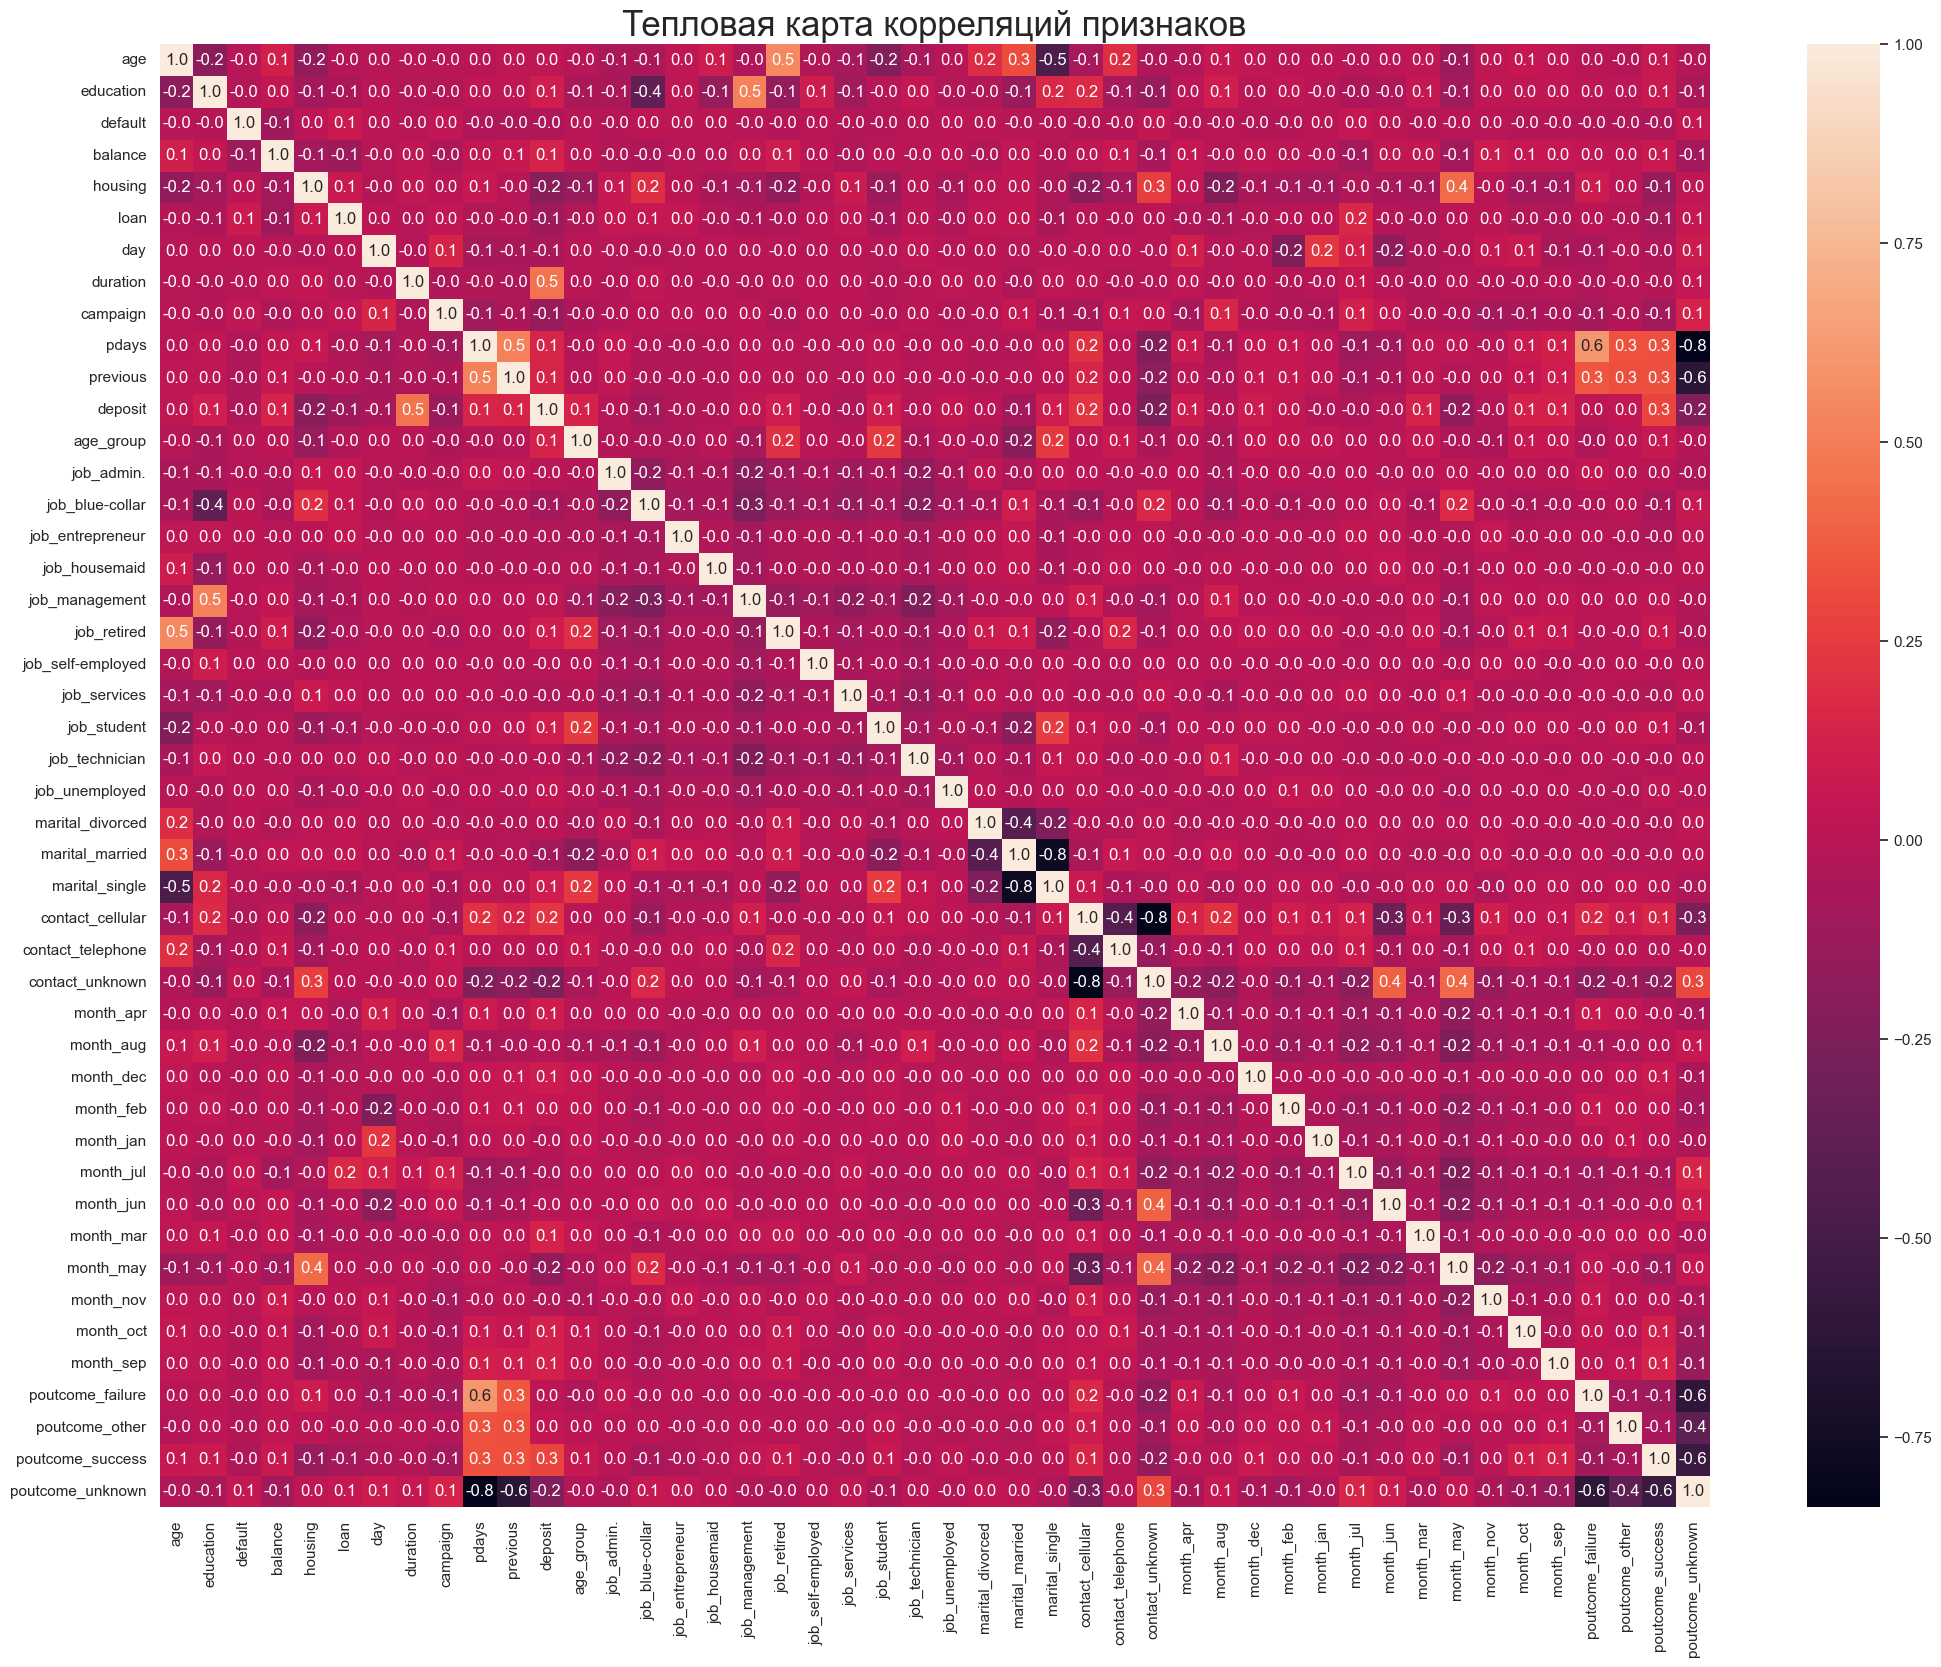

In [221]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

plt.figure(figsize=(25,19))
sns.heatmap(df_new.corr(), annot=True, fmt='.1f')
plt.title('Тепловая карта корреляций признаков', fontsize=25);

*Из тепловой карты корреляции можно заметить, что мультиколлениарность признаков отсутствует. Конечно, можно найти 3 пары признаков с коллениарностью около -0.8, но мы будем считать достаточно сильной корреляцию не менее 0.9 (по модулю)*

### Задания 7 и 8

In [222]:
X = df_new.drop(['deposit'], axis=1)
y = df_new['deposit']

# Разобьем наш датасет на обучающую и тестовую выборки 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [223]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки получился {X_test.shape}')
print(f'Среднее значение целевой переменной на тестовой выборке равно {y_test.mean():.2f}')

Размер тестовой выборки получился (3335, 45)
Среднее значение целевой переменной на тестовой выборке равно 0.46


### Задание 9

In [224]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)

# Выведем наиболее подходящие признаки
top_cols = list(selector.get_feature_names_out())
top_cols

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [225]:
# Оставим только полученные 15 важных признаков и дальше будем работать лишь с усеченной версией датасета

X_train = X_train[top_cols]
X_test = X_test[top_cols]

### Задание 10

In [226]:
# нормализуйте данные с помощью minmaxsxaler

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Среднее арифметическое для первого предиктора из тестовой выборки равно {X_test_scaled[:,0].mean():.2f}')

Среднее арифметическое для первого предиктора из тестовой выборки равно 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [227]:
# обучите логистическую регрессию и рассчитайте метрики качества

log_model = linear_model.LogisticRegression(max_iter=1000,
                                            solver='sag',
                                            random_state=42
                                            )
# Модель линейной регрессии обучаем обязательно на нормализованных данных
log_model.fit(X_train_scaled, y_train)
y_predict = log_model.predict(X_test_scaled)

print(f'Значение accuracy на тестовой выборке равно {metrics.accuracy_score(y_test, y_predict):.2f}')
print(f'Значение F1-метрики на тестовой выборке равно {metrics.f1_score(y_test, y_predict):.2f}')

Значение accuracy на тестовой выборке равно 0.81
Значение F1-метрики на тестовой выборке равно 0.78


*Для базового алгоритма - логистической регрессии получили достаточно неплохое значение метрики accuracy - 0.81. А если взять во внимание, что классы целевой переменной сбалансированы, то для такой простой модели мы получили очень хорошее значение метрики.*

### Задания 2,3,4

In [228]:
# обучите решающие деревья, настройте максимальную глубину
bad_tree_model = tree.DecisionTreeClassifier(criterion = 'entropy',
                                             random_state=42
                                             )

# Обучаем модель и делаем предсказания

bad_tree_model.fit(X_train_scaled, y_train)

y_predict_train = bad_tree_model.predict(X_train_scaled)
y_predict = bad_tree_model.predict(X_test_scaled)

print(f'Значение accuracy на тренировочной выборке равно {metrics.accuracy_score(y_train, y_predict_train):.2f}')
print(f'Значение accuracy на тестовой выборке равно {metrics.accuracy_score(y_test, y_predict):.2f}')

Значение accuracy на тренировочной выборке равно 1.00
Значение accuracy на тестовой выборке равно 0.75


*На трейне модель показывает максимальное accuracy, а на тестовых данных - меньше, чем модель логистической регрессии. Это однозначно говорит о переобучении модели дерева решений - она просто подстроилась под тренирочные данные.*

*Чтобы избежать переобучения, будем подбирать глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения*

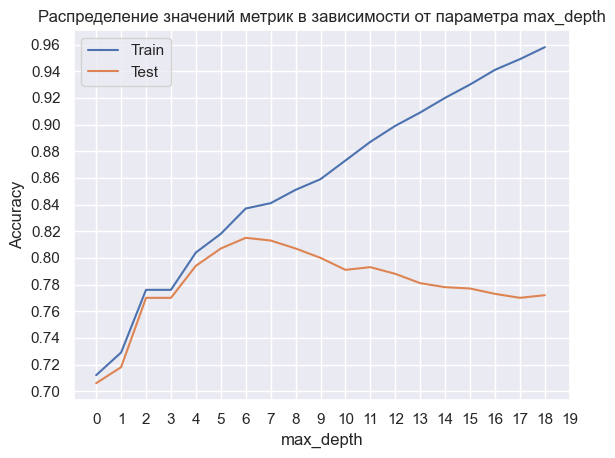

In [229]:
# Для это через цикл переберем все возможные значения для max_depth

accuracy_train = []
accuracy_test = []

for n in range(1, 20):
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             random_state=42,
                                             max_depth=n)
    
    tree_model.fit(X_train_scaled, y_train)
    y_predict_train = tree_model.predict(X_train_scaled)
    y_predict = tree_model.predict(X_test_scaled)
    
    accuracy_train.append(round(metrics.accuracy_score(y_train, y_predict_train),3))
    accuracy_test.append(round(metrics.accuracy_score(y_test, y_predict),3))
    
# Визуализируем полученные значения метрик:
sns.lineplot(accuracy_train, label='Train')
sns.lineplot(accuracy_test, label='Test')
plt.grid()
plt.title('Распределение значений метрик в зависимости от параметра max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.7, 0.97, 0.02))
plt.xticks(range(20))
plt.legend();

*Из графика видно, что оптимальным значением max_depth будет число 6. При нем тестовая метрика максимальна, а также разрыв между трейном и тестом относильно небольшой*

### Задание 5

In [230]:
# подберите оптимальные параметры с помощью gridsearch

# Зададим сетку гиперпараметров модели
param_grid = {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            n_jobs=-1
            )

# Обучаем GridSearch
grid_search.fit(X_train, y_train)
y_predict = grid_search.predict(X_test)

print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")
print(f"accuracy на тестовом наборе: {grid_search.score(X_test, y_test):.2f}")
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_predict):.2f}')

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80


*Видим что перебор нескольких параметров с помощью GridSearch не дал существенного улучшения метрик*

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [231]:
# обучите на ваших данных случайный лес

forest = ensemble.RandomForestClassifier(
            n_estimators = 100,
            criterion = 'gini',
            min_samples_leaf = 5,
            max_depth = 10,
            random_state = 42)

# Обучаем модель случайного леса
forest.fit(X_train_scaled, y_train)
y_predict = forest.predict(X_test_scaled)

print(f'Метрика Accuracy для модели случайного леса равна {metrics.accuracy_score(y_test, y_predict):.2f}')
print(f'Метрика Recall для модели случайного леса равна {metrics.recall_score(y_test, y_predict):.2f}')
print(f'Метрика Precision для модели случайного леса равна {metrics.precision_score(y_test, y_predict):.2f}')
print(f'Метрика F1 для модели случайного леса равна {metrics.f1_score(y_test, y_predict):.2f}')

Метрика Accuracy для модели случайного леса равна 0.83
Метрика Recall для модели случайного леса равна 0.83
Метрика Precision для модели случайного леса равна 0.80
Метрика F1 для модели случайного леса равна 0.82


*Мы немного усложнили модель и уже видим прирост по метрикам. Самое замечательное, что засчет своей структуры, модели
случайного леса не свойственно переобучение.*

### Задания 2 и 3

In [232]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

boosting = ensemble.GradientBoostingClassifier(
                learning_rate = 0.05,
                n_estimators = 300,
                min_samples_leaf = 5,
                max_depth = 5,
                random_state = 42
                )

# Обучаем модель
boosting.fit(X_train_scaled, y_train)
y_predict = boosting.predict(X_test_scaled)

print(f'Метрика Accuracy для модели градиентного бустинга равна {metrics.accuracy_score(y_test, y_predict):.2f}')
print(f'Метрика Recall для модели градиентного бустинга равна {metrics.recall_score(y_test, y_predict):.2f}')
print(f'Метрика Precision для модели градиентного бустинга равна {metrics.precision_score(y_test, y_predict):.2f}')
print(f'Метрика F1 для модели градиентного бустинга равна {metrics.f1_score(y_test, y_predict):.2f}')

Метрика Accuracy для модели градиентного бустинга равна 0.83
Метрика Recall для модели градиентного бустинга равна 0.83
Метрика Precision для модели градиентного бустинга равна 0.80
Метрика F1 для модели градиентного бустинга равна 0.82


*Как мы видим, метрики у моделей случайного леса и градиентного бустинга получились довольно близкими*

### Задание 4

In [233]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создам список с моделями для стейкинга:

estimators = [
        ('tree', tree.DecisionTreeClassifier(
            criterion='entropy',
            random_state=42,
            max_depth=6
            )
    ),
        ('log_reg', linear_model.LogisticRegression(
            max_iter=1000,
            solver='sag',
            random_state=42
            )
    ),  
        ('boosting', ensemble.GradientBoostingClassifier(
            learning_rate = 0.05,
            n_estimators = 300,
            min_samples_leaf = 5,
            max_depth = 5,
            random_state = 42
            )
    )
         
]

In [234]:
stacking = ensemble.StackingClassifier(
            estimators=estimators,
            final_estimator=linear_model.LogisticRegression(
                    max_iter=1000,
                    solver='sag',
                    random_state=42)
            )

# Обучаем модель и делаем предсказание
stacking.fit(X_train_scaled, y_train)
y_predict = stacking.predict(X_test_scaled)

print(f'Метрика Accuracy для модели стейкинга равна {metrics.accuracy_score(y_test, y_predict):.2f}')
print(f'Метрика Precision для модели стейкинга равна {metrics.precision_score(y_test, y_predict):.2f}')

Метрика Accuracy для модели стейкинга равна 0.82
Метрика Precision для модели стейкинга равна 0.81


*С помощью стекинга нам немного удалось улучшишь метрику precision*

### Задание 5

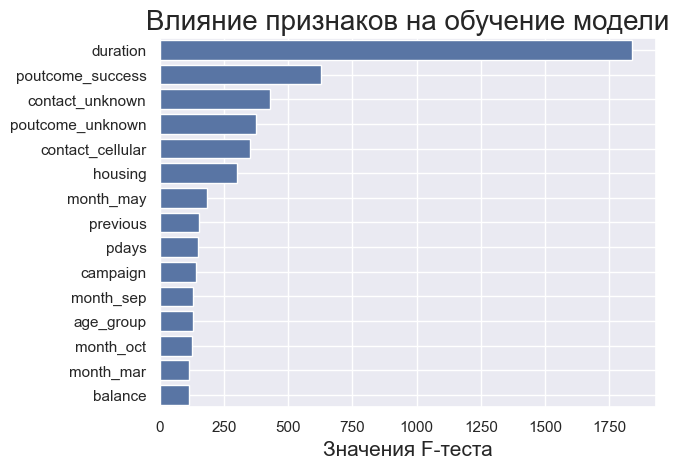

In [235]:
# С помощью F-теста проверим какие признаки будут вносить наибольший вклад

from sklearn.feature_selection import f_classif # anova

columns=X_train.columns

columns_rating = pd.Series(f_classif(X_train_scaled, y_train)[0], index = columns)
columns_rating.sort_values(inplace = True, ascending=False)
sns.barplot(columns_rating, orient='h')
plt.title('Влияние признаков на обучение модели', size=20)
plt.xlabel('Значения F-теста', fontsize=15)
plt.grid();

Попробуем совместить значения для признаков *f_classif* и важность признаков при обучении градиентного бустинга

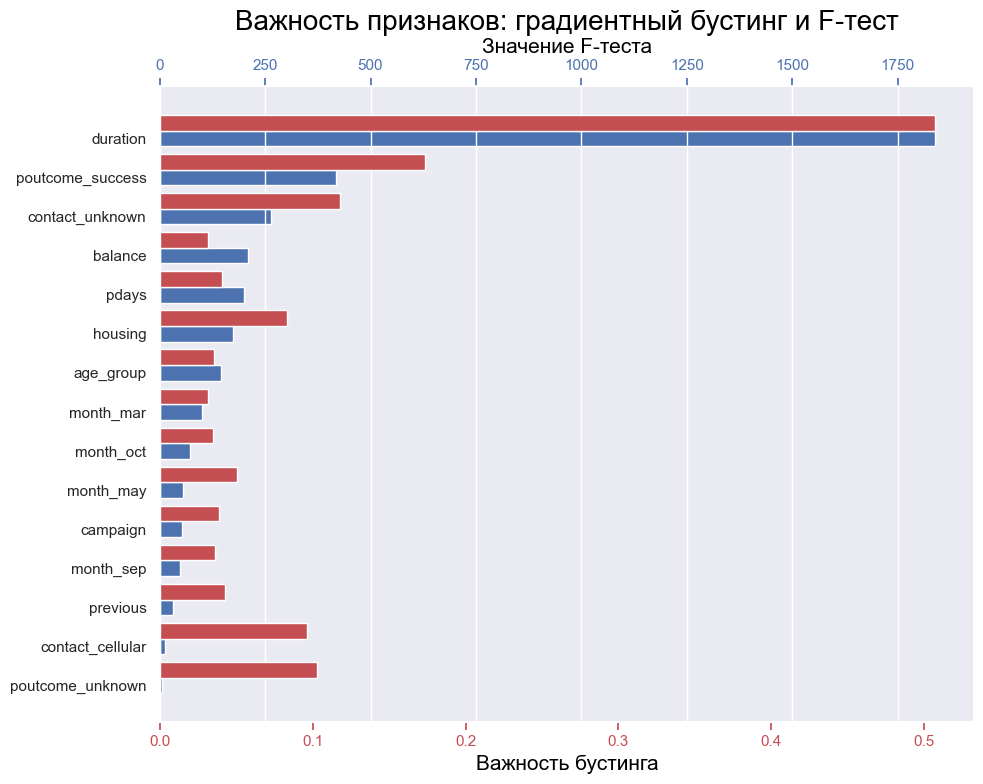

In [236]:
# Важность признаков из бустинга
boosting_importances = pd.Series(boosting.feature_importances_, index=X_test.columns, name='Boosting Importance')

# Результаты f_classif (F-тест)
f_values = pd.Series(f_classif(X_train_scaled, y_train)[0], index=X_train.columns, name='F-test Score')

# Объединяем в один DataFrame
df = pd.concat([boosting_importances, f_values], axis=1)

# Сортируем по одному из критериев, например, по важности бустинга
df = df.sort_values('Boosting Importance', ascending=True)

fig, ax1 = plt.subplots(figsize=(10, 8))

indices = np.arange(len(df))
bar_width = 0.4

# Первая ось — важность бустинга
ax1.barh(indices, df['Boosting Importance'], height=bar_width, color='b', label='Важность бустинга')
ax1.set_xlabel('Важность бустинга', color='black', fontsize=15)
ax1.tick_params(axis='x', colors='r')

ax1.set_yticks(indices)
ax1.set_yticklabels(df.index)

# Вторая ось — F-тест
ax2 = ax1.twiny()
ax2.barh(indices + bar_width, df['F-test Score'], height=bar_width, color='r', label='F-тест')
ax2.set_xlabel('Значение F-теста', color='black', fontsize=15)
ax2.tick_params(axis='x', colors='b')

plt.title('Важность признаков: градиентный бустинг и F-тест', size=20, color='black')
fig.tight_layout()
plt.grid();



*Видим, что признак duration оказывает наибольшее влияние на обучение модели, что на f-тесте, что для градиентного бустинга.
Однако с остальными признаками не все так однозначно. 14 и 15 признаки по важности для KBest(f-classic) занимают не последнее место у модели градиентного бустинга. Вероятно, если обучить модель градиентного бустинга на других/всех признаках датасета, то мы получим прибавку по метрикам.*

### Задания 6,7,8

In [240]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

def optuna_forest(trial):
    """
    Функция, обучающая модель Random Forest
    по переданным гиперпараметрам
    
    Args: trial : класс, от которого вызываются гиперпараметры
    Returns: score(float): метрика F1
    """ 
    # задаем пространства поиска гиперпараметров
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  

    forest_model_optuna = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )
        
    # Обучаем модель и делаем предсказание
    forest_model_optuna.fit(X_train_scaled, y_train)
    y_predict = forest_model_optuna.predict(X_test_scaled)
    
    return metrics.f1_score(y_test, y_predict)


In [241]:
# cоздаем объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# Ищем лучшую комбинацию 50 раз
study.optimize(optuna_forest, n_trials=50)

[I 2025-07-04 20:01:17,501] A new study created in memory with name: RandomForestClassifier
[I 2025-07-04 20:01:17,905] Trial 0 finished with value: 0.818239392020266 and parameters: {'n_estimators': 102, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.818239392020266.
[I 2025-07-04 20:01:18,420] Trial 1 finished with value: 0.8170616113744077 and parameters: {'n_estimators': 120, 'max_depth': 14, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.818239392020266.
[I 2025-07-04 20:01:18,925] Trial 2 finished with value: 0.8119440914866582 and parameters: {'n_estimators': 147, 'max_depth': 30, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.818239392020266.
[I 2025-07-04 20:01:19,427] Trial 3 finished with value: 0.8193832599118942 and parameters: {'n_estimators': 152, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.8193832599118942.
[I 2025-07-04 20:01:19,752] Trial 4 finished with value: 0.8147676639083387 and parameters: {'n_est

In [242]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print(' ')

# рассчитаем точность для тестовой выборки после 100 итераций
forest_model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
forest_model.fit(X_train_scaled, y_train)

y_train_pred = forest_model.predict(X_train_scaled)
y_test_pred = forest_model.predict(X_test_scaled)

print("f1_score на обучающем наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Accuracy на тестовом наборе данных:  {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 6}
 
f1_score на обучающем наборе: 0.86
f1_score на тестовом наборе: 0.82
Accuracy на тестовом наборе данных:  0.83


*Подбор гиперпараметров для модели случайного леса с помощью Optuna позволил нам улучшить предыдущий показатель F1 c 0.81 => 0.82. Значение метрики Accuracy, к сожалению осталось неизменным*

#### Вывод

Для решения задачи классификации в данном кейсе хорошо себя показали модели бустинга и стэкинга, а также модель случайного леса с подобранными гиперпараметрами методом Optuna.

В ходе исследования выделили, что наиболее важным признаком является *duration* (продолжительность контакта в секундах). Это показывает, что превалирующее значение в решении открыть клиентом депозит(со стороны клиента) играют внешние факторы,  продолжительность контакта, тип контакта с клиентом т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение лаконично и доступно излагать информацию клиентам и т.д.

Также стоит упомянуть о лояльности клиентах - как показали исследования клиентов ранее открывшие депозиты в прошлые маркетиновые кампании охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность. При планировании новой маркетинговой кампании необходимо обязательно более тщательно подходить к вопросу выбора контакта с клиентом - в данной кампании порядка 21% вид контакта неизвестен, данный факт касается также и poutcome (результат прошлой маркетинговой кампании).